In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import tensorflow.keras as keras

In [2]:
FILE_PATH = 'data/weatherAUS_cleaned.csv'

In [3]:
# Get cleaned data from csv
df = pd.read_csv(FILE_PATH)
df.loc[:, "Date"] = pd.to_datetime(df.loc[:, "Date"])
df

,Date,MinTemp,MaxTemp,Evaporation,Sunshine,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Rain
0,2009-01-01 00:00:00,17.7,35.1,9.8,12.9,63.0,13.0,1005.3,1000.2,22.9,34.0,0.0
1,2009-01-02 00:00:00,18.5,23.0,11.0,5.9,63.0,58.0,1012.9,1014.1,20.6,20.1,0.0
2,2009-01-03 00:00:00,16.9,23.2,9.0,0.5,52.0,50.0,1021.8,1019.4,18.9,22.0,0.0
3,2009-01-04 00:00:00,18.7,27.1,5.4,11.3,60.0,51.0,1018.5,1014.9,22.9,25.9,0.0
4,2009-01-05 00:00:00,20.2,31.6,10.0,12.2,58.0,52.0,1013.2,1008.0,24.9,29.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3004,2017-06-21 00:00:00,8.6,18.6,2.0,7.8,69.0,67.0,1025.7,1025.3,13.3,17.7,0.2
3005,2017-06-22 00:00:00,9.5,17.8,2.0,9.2,74.0,70.0,1028.3,1024.6,14.3,16.8,0.2
3006,2017-06-23 00:00:00,8.7,19.4,2.4,2.7,83.0,57.0,1020.8,1014.7,10.9,18.2,0.0
3007,2017-06-24 00:00:00,9.4,19.9,1.4,9.3,61.0,41.0,1017.3,1015.2,12.9,19.3,0.0


## Segui o modelo do link
https://keras.io/examples/timeseries/timeseries_weather_forecasting/ 

In [4]:
# Standardize dataset

def get_data_params(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return data_mean, data_std

def standardize(data, data_mean, data_std):
    return (data - data_mean) / data_std

def unstandardize(data, data_mean, data_std):
    return (data * data_std) + data_mean

# Model params
split_fraction = 0.7
train_split = int(split_fraction * int(df.shape[0]))
step = 1

past = 30
future = 0
learning_rate = 0.001
batch_size = 128
epochs = 50

# Split date
features = df.drop(columns=["Date"])
data_mean, data_std = get_data_params(features.values, train_split)
features = standardize(features.values, data_mean=data_mean, data_std=data_std)
features = pd.DataFrame(features)

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

val_data

,0,1,2,3,4,5,6,7,8,9,10
2106,1.281035,0.529320,1.782529,-0.996630,1.010260,0.893834,0.161123,0.434101,0.709626,0.398862,-0.319211
2107,1.432928,1.128410,-0.425991,1.203670,1.382101,0.028381,0.379507,0.578104,0.955229,1.195214,-0.319211
2108,1.628219,1.667591,0.531034,1.360834,-0.663021,-0.782981,0.321272,0.275698,2.004625,1.740085,-0.319211
2109,1.454627,1.527803,1.488060,1.517998,-0.601048,-0.566618,-0.319322,-0.645921,1.736694,1.823912,-0.319211
2110,1.671617,2.027045,3.107641,0.391654,-0.043287,-0.133891,-1.120064,-1.250733,1.959970,1.719129,-0.319211
...,...,...,...,...,...,...,...,...,...,...,...
3004,-1.322846,-0.908497,-1.162165,0.155908,0.266580,0.731562,1.078337,1.355720,-1.121234,-0.816621,-0.296814
3005,-1.127555,-1.068254,-1.162165,0.522625,0.576447,0.893834,1.456869,1.254918,-0.897958,-1.005231,-0.296814
3006,-1.301147,-0.748739,-1.014930,-1.179988,1.134207,0.190653,0.364948,-0.170711,-1.657095,-0.711838,-0.319211
3007,-1.149254,-0.648891,-1.383017,0.548819,-0.229207,-0.674800,-0.144615,-0.098710,-1.210544,-0.481315,-0.319211


In [5]:
# Train Dataset
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(len(df.columns)-1)]].values
y_train = features.iloc[start:end][[len(df.columns)-2]]

sequence_length = int(past / step)

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [6]:
# Validation data
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(len(df.columns)-1)]].values
y_val = features.iloc[label_start:][[len(df.columns)-2]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (128, 30, 11)
Target shape: (128, 1)


In [7]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 11)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5632      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5665 (22.13 KB)
Trainable params: 5665 (22.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
path_checkpoint = "weights/model_checkpoint.h5"

load_model = False

if load_model:
    model.load_weights(path_checkpoint)
else:
    es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=20)

    modelckpt_callback = keras.callbacks.ModelCheckpoint(
        monitor="val_loss",
        filepath=path_checkpoint,
        verbose=1,
        save_weights_only=True,
        save_best_only=True,
    )

    history = model.fit(
        dataset_train,
        epochs=epochs,
        validation_data=dataset_val,
        callbacks=[es_callback, modelckpt_callback],
    )

Epoch 1/50
13/17 [=====================>........] - ETA: 0s - loss: 1.0054
Epoch 1: val_loss improved from inf to 1.09038, saving model to weights\model_checkpoint.h5
17/17 [==============================] - 3s 45ms/step - loss: 0.9594 - val_loss: 1.0904
Epoch 2/50
14/17 [=======================>......] - ETA: 0s - loss: 0.8974
Epoch 2: val_loss improved from 1.09038 to 1.04103, saving model to weights\model_checkpoint.h5
17/17 [==============================] - 0s 19ms/step - loss: 0.8960 - val_loss: 1.0410
Epoch 3/50
15/17 [=========================>....] - ETA: 0s - loss: 0.8302
Epoch 3: val_loss improved from 1.04103 to 1.00903, saving model to weights\model_checkpoint.h5
17/17 [==============================] - 0s 18ms/step - loss: 0.8665 - val_loss: 1.0090
Epoch 4/50
13/17 [=====================>........] - ETA: 0s - loss: 0.8809
Epoch 4: val_loss improved from 1.00903 to 0.98276, saving model to weights\model_checkpoint.h5
17/17 [==============================] - 0s 19ms/step - 

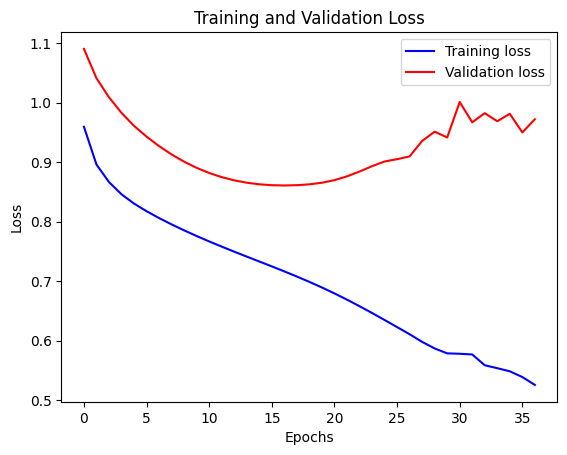

In [9]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

4/4 [==============================] - 0s 4ms/step


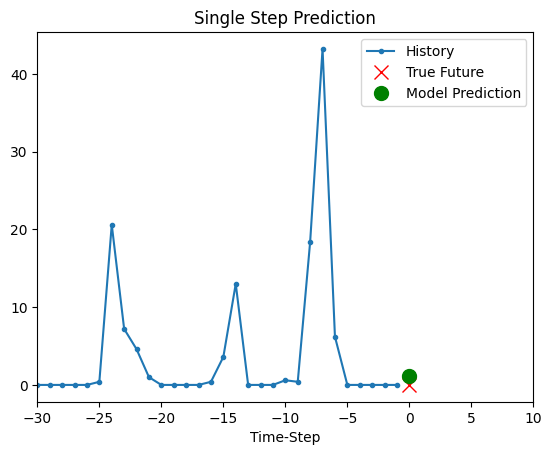

True Value: [0.], Prediction: [1.1219643]


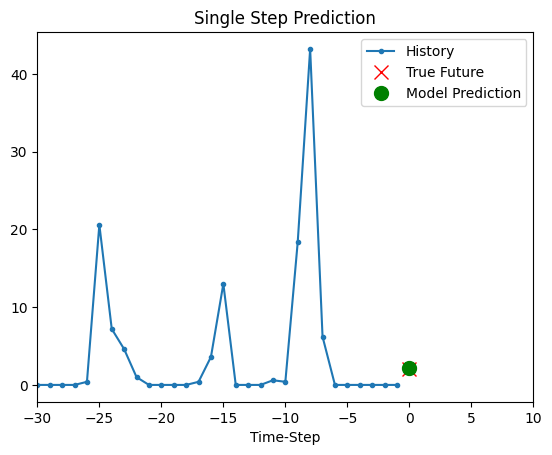

True Value: [2.], Prediction: [2.1608791]


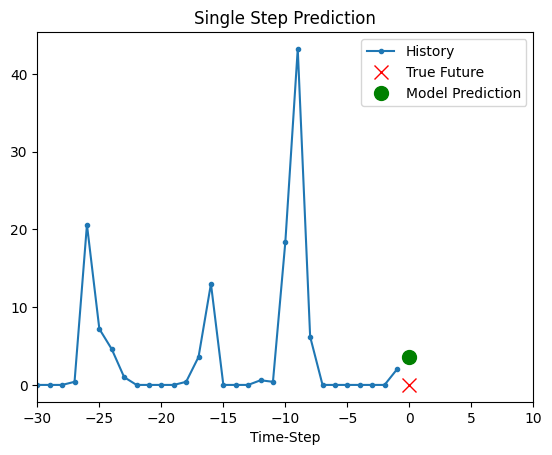

True Value: [0.], Prediction: [3.6315436]


In [13]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, _ in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return 

for x, y in dataset_val.take(1):
    pred = unstandardize(model.predict(x), data_mean=data_mean[-1], data_std=data_std[-1])
    x = unstandardize(x.numpy(), data_mean=data_mean, data_std=data_std)
    y = unstandardize(y.numpy(), data_mean=data_mean[-1], data_std=data_std[-1])
    for i in range(3):
        show_plot(
            [x[i][:, -1], 
            y[i], 
            pred[i]],
            future,
            "Single Step Prediction",
        )
        print(f"True Value: {y[i]}, Prediction: {pred[i]}")

In [14]:
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['figure.dpi'] = 150
plt.ioff()

delta = 0
title = "Single Step Prediction"

fig, ax = plt.subplots()

for x, y in dataset_val.take(1):
    pred = unstandardize(model.predict(x), data_mean=data_mean[-1], data_std=data_std[-1])
    x = unstandardize(x.numpy(), data_mean=data_mean, data_std=data_std)
    y = unstandardize(y.numpy(), data_mean=data_mean[-1], data_std=data_std[-1])
    plot_data = [x[0][:, -1], 
                y[0], 
                pred[0]]
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    plt_elements = [0, 0, 0]
    for i, _ in enumerate(plot_data):
        if i:
            plt_elements[i] = ax.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])[0]
        else:
            plt_elements[i] = ax.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])[0]
    plt_elements.append(plt.text(-28, 40, f"True Value: {y[i]}, Prediction: {pred[i]}", dict(size=8)))
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")


def update(frame):
    # For each frame, update the data stored on each artist.
    plot_data = [x[frame][:, -1], 
                y[frame], 
                pred[frame]]
    # Update plot elements:
    for i, _ in enumerate(plot_data):
        if i:
            plt_elements[i].set_xdata(future)
            plt_elements[i].set_ydata(plot_data[i])
        else:
            plt_elements[i].set_xdata(time_steps)
            plt_elements[i].set_ydata(plot_data[i].flatten())
        plt_elements[-1].set_text(f"True Value: {y[frame]}, Prediction: {pred[frame]}")
    return tuple(plt_elements)


anim = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=2000)
anim

4/4 [==============================] - 0s 4ms/step


C:\Users\joaof\AppData\Local\Temp\ipykernel_8628\3369851939.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  plt_elements[i].set_xdata(future)
